## Echoes Of Chaos

In [6]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'

In [ ]:
%run "../setup/Setup_Generic.ipynb"
scope.adc.samples = 100000

INFO: Found ChipWhisperer😍


In [11]:
cw.program_target(scope, prog, "chaos-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 14307 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 14307 bytes


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import pyvisa as visa
import pandas as pd
from tqdm import tqdm
import time
import os

## Capture and Save Power Traces

In [ ]:
plaintexts = []
power_traces = []

num_trace_per_group = 5000

start_trace = 60001
num_traces = 256*256

for i in range(start_trace, num_traces + 1):

    plaintext = [(i-1)%256, (i-1)//256] * 15
    print("Plaintext:", plaintext)

    # Arm the Chipwhisper
    scope.arm()

    target.simpleserial_write('a', bytearray(plaintext))

    # resp = target.simpleserial_read('r', 20)

    # if resp is not None:
    #     print("b: ", resp)

    # Capture the power trace
    ret = scope.capture()
    
    if ret:
        print('Timeout happened during acquisition')

    # Read the power trace from the ChipWhisperer Nano
    power_trace = scope.get_last_trace()

    # Append the power trace to the list of power traces
    plaintexts.append(plaintext)

    # For dummy
    # power_traces.append(power_trace[53750:54050])

    # Real
    # power_traces.append(power_trace[57800:58350])
    power_traces.append(power_trace[57000:58500])


    if (((i % num_trace_per_group) == 0) or (i == num_traces)):
        print("Save ")
        traces = np.array(power_traces)
        data = {'power_traces': traces, "plaintexts":plaintexts}

        if (i == num_traces):
            numb = (i // num_trace_per_group) + 1
        else:
            numb = (i // num_trace_per_group)

        print((numb))
        print(i)

        np.savez("./Traces/echoesOfChaos/power_traces_and_plaintexts_1_" + str(numb) + ".npz", **data)

        plaintexts.clear()
        power_traces.clear()

✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_1.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_2.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_3.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_4.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_5.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully from '/home/dakshina/projects/csaw_esc_2025/Traces/echoesOfChaos/power_traces_and_plaintexts_1_6.npz'.
Found 5000 traces to visualize.
✅ Data loaded successfully f

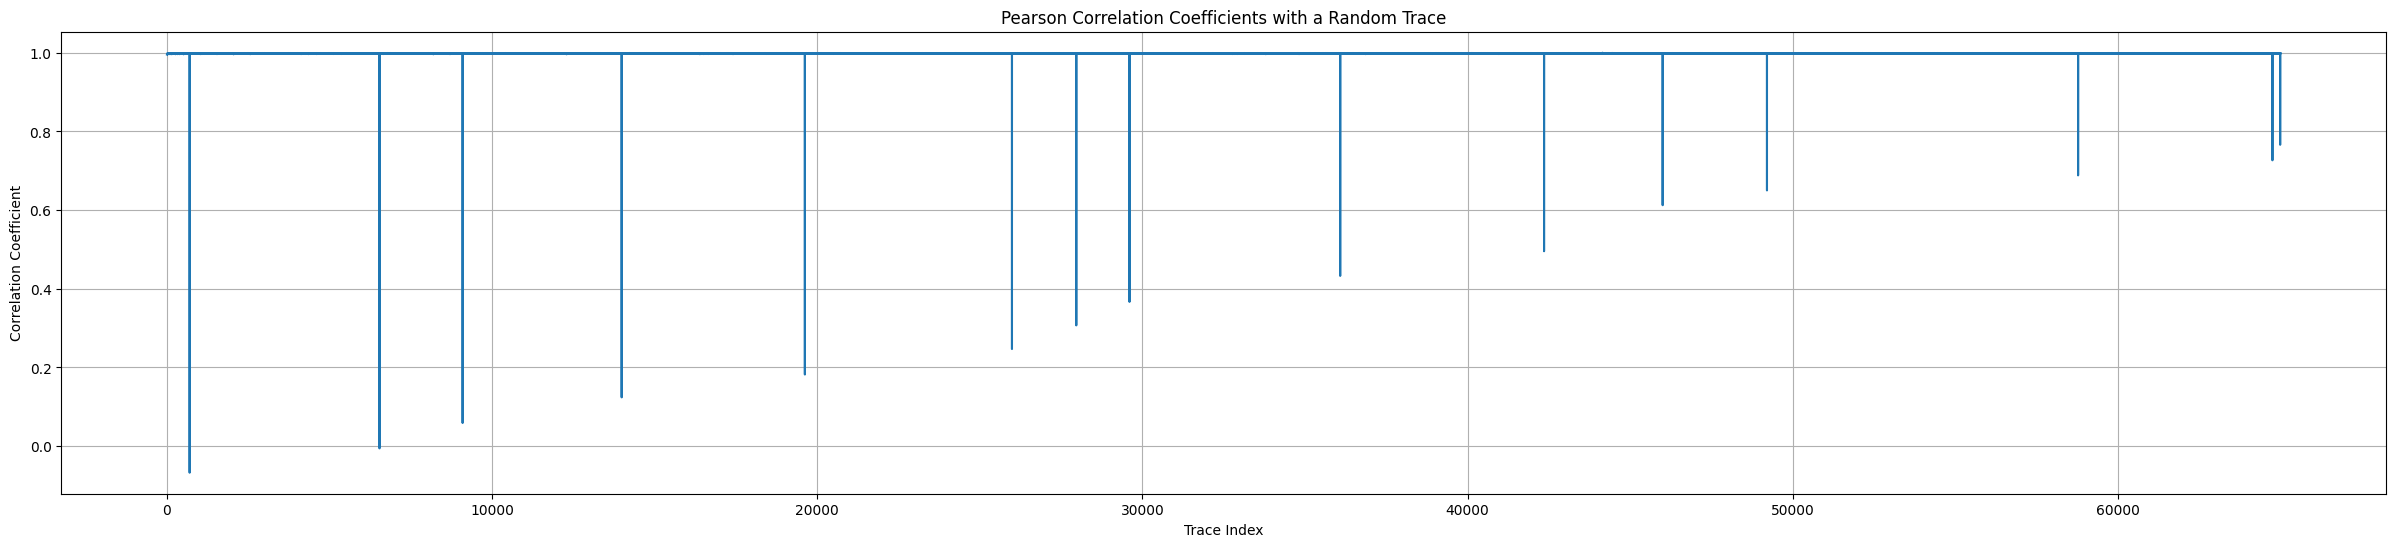

In [ ]:

cropped_traces = None
num_trace_per_group = 5000

for num_files in range(1, int((256*256)//num_trace_per_group)+1):

    try:
        input_file = './Traces/echoesOfChaos/power_traces_and_plaintexts_1_'+ str(num_files) +'.npz'
        data = np.load(input_file)
    except FileNotFoundError:
        print(f"Error: File not found at '{input_file}'.")
        print("Make sure you run the capture and save script first.")
        exit()

    loaded_traces = data['power_traces']
    loaded_plaintexts = data['plaintexts']

    print(f"✅ Data loaded successfully from '{input_file}'.")
    print(f"Found {len(loaded_traces)} traces to visualize.")

    if cropped_traces is None:
        # For dummy
        # cropped_traces = np.array(loaded_traces)

        # For real
        cropped_traces = np.array(loaded_traces[:,800:1400])

    else:
        # For dummy
        # cropped_traces = np.concatenate((cropped_traces, np.array(loaded_traces)))

        # For real
        cropped_traces = np.concatenate((cropped_traces, np.array(loaded_traces[:,800:1400])))



cropped_traces = np.array(cropped_traces)
print(len(cropped_traces))


for i in range(0,17):

    random_index = random.randint(0, len(cropped_traces) - 1)

    print(random_index)
    random_trace = cropped_traces[random_index]

    correlations = [pearsonr(random_trace, trace_temp)[0] for trace_temp in cropped_traces]
    correlations = np.array(correlations)

    mean = np.mean(correlations)

    plt.figure(figsize=(30, 6))
    plt.plot(correlations)

    # plt.xticks(ticks=range(0, 256*256), labels=range(0, 256*256), rotation=90)
    plt.title("Pearson Correlation Coefficients with a Random Trace")
    plt.xlabel("Trace Index")
    plt.ylabel("Correlation Coefficient")
    plt.grid(True)
    plt.show()

    if mean < 0.5:
        continue
    else:
        break


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def zncc_1d(signal: np.ndarray, template: np.ndarray):
    """
    Z-normalized cross-correlation (1D) producing 'valid' positions only.
    Returns an array of length len(signal) - len(template) + 1 with scores in [-1, 1].
    """
    s = np.asarray(signal, dtype=float)
    t = np.asarray(template, dtype=float)
    M = len(t)
    if M > len(s):
        raise ValueError("Template must be shorter than or equal to the signal.")

    # template stats
    t_mean = t.mean()
    t_centered = t - t_mean
    t_std = t_centered.std(ddof=0)
    if t_std == 0:
        raise ValueError("Template has zero variance; ZNCC is undefined.")

    # rolling sums over the signal using convolution with a ones window
    w = np.ones(M, dtype=float)
    sum_s  = np.convolve(s, w, mode='valid')
    sum_s2 = np.convolve(s*s, w, mode='valid')

    mean_s = sum_s / M
    var_s  = (sum_s2 / M) - (mean_s**2)
    var_s[var_s < 0] = 0.0                         # numerical guard
    std_s  = np.sqrt(var_s)
    std_s[std_s == 0] = np.inf                     # avoid div-by-zero => score 0

    # numerator: sum( (s_win - mean_s)* (t - mean_t) )
    # = sum(s_win * (t - mean_t)) - M*mean_s*0  (since sum(t - mean_t) = 0)
    # compute via conv with reversed centered template
    num = np.convolve(s, t_centered[::-1], mode='valid')

    # denominator: sqrt( M*var_s ) * sqrt( M*var_t ) = M * std_s * t_std
    den = M * std_s * t_std

    zncc = num / den
    zncc[np.isinf(zncc)] = 0.0
    zncc = np.clip(zncc, -1.0, 1.0)
    return zncc

def find_template_matches(signal, template, threshold=0.8, min_separation=None):
    """
    Returns (match_indices, scores, zncc_curve)
    match_indices are start positions in 'signal' where template matches.
    """
    zncc = zncc_1d(signal, template)
    M = len(template)
    if min_separation is None:
        min_separation = max(1, M // 2)  # avoid overlapping duplicate hits

    # pick local maxima above threshold
    peaks, props = find_peaks(zncc, height=threshold, distance=min_separation)
    return peaks, props["peak_heights"], zncc

# If starting point identification
min_start = 5000

#### Saved Template ####
# For dummy
# if_template = cropped_traces[0][17:35]

# For real
if_template = cropped_traces[0][46:77]

for trace in cropped_traces:
    long_trace = trace
    template = if_template

    # Find matches
    idxs, scores, zncc = find_template_matches(long_trace, template, threshold=0.7)

    # print("Match starts:", idxs.tolist())
    # print("Match scores:", [round(s, 3) for s in scores])

    if (min_start > idxs.tolist()[0]):
        min_start = idxs.tolist()[0]

print(min_start)

46


In [4]:
cor_threshold = 0.8

flag_length = 15

# For dummy
# peak_thresh = 0.9

# For real
peak_thresh = 0.75

template = if_template

sel_array = np.sort(np.where(correlations < cor_threshold)[0])
print(sel_array)

# Create template matching index array
if_check_pos = np.array([(1)+ len(template)*(i) for i in range(flag_length)])
print(if_check_pos)

correct_flag = [0]* flag_length

if len(sel_array) != flag_length:
    for sel_index in sel_array:

        print(sel_index)

        # Crop the trace capturing exactly the if checkings
        long_trace_comp = cropped_traces[sel_index][(min_start-1):min_start+ (len(template)*(flag_length + 2))]

        # Find matches
        idxs, scores, zncc = find_template_matches(long_trace_comp, template, threshold=peak_thresh)

        match_start = np.array(idxs.tolist())

        limit = flag_length - len(sel_array) + 1                      # distance limit

        # Compute pairwise absolute differences
        diff = np.abs(if_check_pos[:, None] - match_start[None, :])

        # For each element in a, check if ALL distances > limit
        mask = np.all(diff > limit, axis=1)

        # Get elements in a that are NOT within 'limit' of any number in b
        result = if_check_pos[mask]

        print("Match starts:", idxs.tolist())
        print("Match scores:", [round(s, 3) for s in scores])

        # Plot correlation + locations on the trace
        plt.figure(figsize=(10, 6))

        # Correlation curve
        plt.subplot(2,1,1)
        plt.plot(zncc)
        plt.axhline(peak_thresh, linestyle="--")
        for i in idxs:
            plt.axvline(i, linestyle=":")
        plt.title("ZNCC (template vs. signal)")

        # Signal with match markers
        plt.subplot(2,1,2)
        plt.plot(long_trace_comp)
        for i in idxs:
            # show the span of the match
            plt.axvspan(i, i+len(template), alpha=0.2)
        plt.title("Signal with matched regions highlighted")
        plt.tight_layout()
        plt.show()

        print("Elements not within limit :", result)

        miss_index = [np.where(if_check_pos == x)[0][0] for x in result if x in if_check_pos]

        for miss in miss_index:
            correct_flag[miss] = sel_index

else:
    correct_flag = sel_array

print(correct_flag)



[  697  6536  9092 13983 19617 25986 27964 29600 36080 42349 45996 49204
 58772 64748 64986]
[  1  32  63  94 125 156 187 218 249 280 311 342 373 404 435]
[  697  6536  9092 13983 19617 25986 27964 29600 36080 42349 45996 49204
 58772 64748 64986]


In [14]:
correct_pass = [0]*30

for index, i in enumerate(correct_flag):
    correct_pass[2*index] = (i)%256
    correct_pass[2*index+1] = (i)//256

target.simpleserial_write('a', bytes(correct_pass)) 
resp = target.simpleserial_read('r', 20)
if resp is not None:
    print("b: ", resp)

b:  bytearray(b'eoc{th3yreC00ked}   ')
